In [1]:
from datetime import datetime
import gsw
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator
import pandas as pd
import xarray as xr

from ONCToolbox import ONCToolbox
from ONCToolbox.utils import nan_onc_flags, remove_onc_flag_vars
from ONCToolbox.utils.profilers import identify_profiles, identify_stops
from ONCToolbox.utils.locations import VPS as VPSLoc

## Setup Request Parameters and Instantiate ONCToolbox

In [2]:
begin_datetime = datetime(2025,6,14,22,0,0,0)
end_datetime = datetime(2025,6,15,23,59,59,999999)

onct = ONCToolbox()

## Download and Combine Data by Time

In [3]:
doi = onct.find_data('BACVP', ['DC90','CTD'], begin_datetime, end_datetime)
datasets = []
for loc_code, dev_deps in doi.items():
    for dcc, dep_info in dev_deps.items():
        data = onct.get_data(loc_code, dcc, begin_datetime=begin_datetime,end_datetime=end_datetime)
        datasets.append(data)
ds = xr.combine_by_coords(datasets, combine_attrs='drop_conflicts')

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 2 pages in total.
Estimated approx. 15 seconds to complete for the rest of the pages.

   (62500 samples) Downloading page 2...
   (92306 samples) Completed in 23 seconds.
Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 4 pages in total.
Estimated approx. 33 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (363278 samples) Completed in 41 seconds.


## Clean and Rename Variables

In [4]:
ds = nan_onc_flags(ds)
ds = remove_onc_flag_vars(ds)
ds = ds.rename({'conductivity':'sea_water_electrical_conductivity', 'temperature':'sea_water_temperature', 'pressure':'sea_water_pressure'})
ds = ds[['cable_length','sea_water_pressure','sea_water_electrical_conductivity','sea_water_temperature']]

## Parse Out Cable Length and Split into Stops and Profiles

In [5]:
# Parse out cable length to be used to split profiles and stops.
cable_length = ds.cable_length.dropna(dim = 'time', how = 'all').round(2) # Round to nearest centimeter.

In [6]:
stops = identify_stops(cable_length, buffer = 0, max_allowed_std=0.01)
parked = [v for v in stops if v['cable_length_out'] <= 3]

In [7]:
up_profiles = identify_profiles(cable_length, profile_direction = 'up',buffer = 10)

## Analyze Stops

In [8]:
# Combine and smooth stop data.
pds = xr.combine_by_coords([ds.sel(time=slice(v['begin_datetime'], v['end_datetime'])) for v in parked], combine_attrs='drop_conflicts')
pds = pds.dropna(dim = 'time', how = 'all')
pds = pds.rolling({'time': 61}, center=True, min_periods=1).median(skipna = True) # Apply a rolling median to smooth the data.

# Recompute derived variables.
pds['sea_water_practical_salinity'] = gsw.SP_from_C(pds.sea_water_electrical_conductivity*10, pds.sea_water_temperature, pds.sea_water_pressure)
pds['sea_water_absolute_salinity'] = gsw.SA_from_SP(pds.sea_water_practical_salinity, pds.sea_water_pressure,lon = VPSLoc.lon, lat = VPSLoc.lat)
pds['sea_water_conservative_temperature'] = gsw.CT_from_t(pds.sea_water_absolute_salinity, pds.sea_water_temperature, pds.sea_water_pressure)
pds['sea_water_density'] = gsw.density.rho(pds.sea_water_absolute_salinity, pds.sea_water_conservative_temperature, pds.sea_water_pressure)
pds['sea_water_potential_density'] = gsw.sigma0(pds.sea_water_absolute_salinity, pds.sea_water_conservative_temperature)
pds['depth'] = gsw.z_from_p(pds.sea_water_pressure, VPSLoc.lat)*-1

Text(0.5, 1.0, 'Sea Water Potential Density At Seafloor Parking Depth')

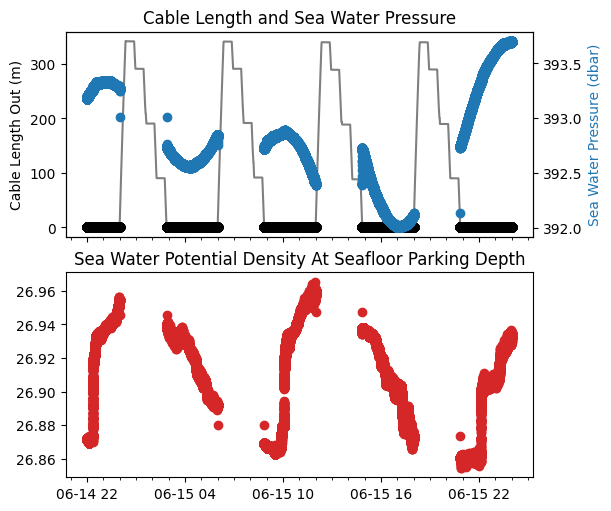

In [9]:
fig, ax = plt.subplots(2,1,figsize = (6,5), constrained_layout = True, sharex = True)

ax[0].plot(cable_length.time, cable_length, color = 'k', label = 'Cable Length', zorder = 0, alpha = 0.5)

ax[0].scatter(pds.time, pds.cable_length, color = 'k', label = 'Cable Length', zorder = 0, alpha = 0.5)
ax2 = ax[0].twinx()
ax2.scatter(pds.time, pds.sea_water_pressure, color = 'tab:blue', label = 'Sea Water Pressure', zorder = 1)
ax[0].set_ylabel('Cable Length Out (m)')
ax2.set_ylabel('Sea Water Pressure (dbar)', color = 'tab:blue')


ax[1].scatter(pds.time, pds.sea_water_potential_density, color = 'tab:red')

ax[-1].xaxis.set_major_locator(HourLocator(interval = 6))
ax[-1].xaxis.set_minor_locator(HourLocator(interval = 1))

ax[0].set_title('Cable Length and Sea Water Pressure')

ax[1].set_title('Sea Water Potential Density At Seafloor Parking Depth')

## Analyze Up Profiles

In [10]:
pros = []
for upp in up_profiles:
    pro = ds.sel(time=slice(upp['begin_datetime'], upp['end_datetime']))
    pro = pro.sortby('time')
    pro = pro.assign_coords({'profile_id': [pd.to_datetime(pro.time.min().values).strftime('%Y%m%dT%H%M%SZ')]})
    pro = pro.dropna(dim = 'time', how = 'all')
    pro = pro.rolling({'time': 5}, center=True, min_periods=1).median(skipna = True) # Apply a rolling median to smooth the data.
    pro['sea_water_practical_salinity'] = gsw.SP_from_C(pro.sea_water_electrical_conductivity*10, pro.sea_water_temperature, pro.sea_water_pressure)
    pro['sea_water_absolute_salinity'] = gsw.SA_from_SP(pro.sea_water_practical_salinity, pro.sea_water_pressure,lon = VPSLoc.lon, lat = VPSLoc.lat)
    pro['sea_water_conservative_temperature'] = gsw.CT_from_t(pro.sea_water_absolute_salinity, pro.sea_water_temperature, pro.sea_water_pressure)
    pro['sea_water_density'] = gsw.density.rho(pro.sea_water_absolute_salinity, pro.sea_water_conservative_temperature, pro.sea_water_pressure)
    pro['sea_water_potential_density'] = gsw.sigma0(pro.sea_water_absolute_salinity, pro.sea_water_conservative_temperature)
    pro['depth'] = gsw.z_from_p(pro.sea_water_pressure, VPSLoc.lat)*-1
    pros.append(pro)

Text(0.5, 0, 'Sea Water Potential Density ($\\frac{kg}{m^3}$)')

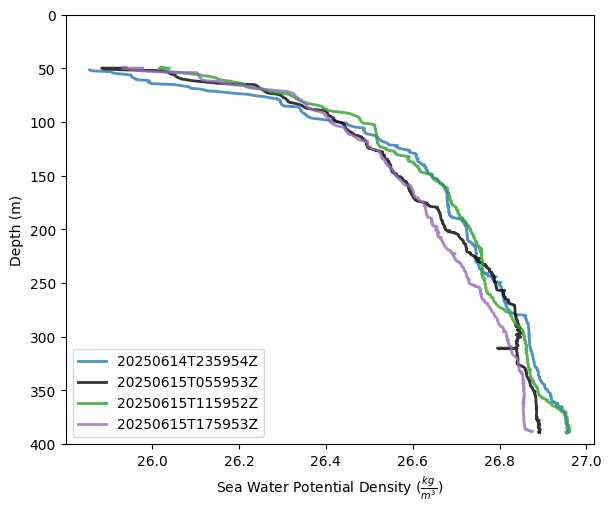

In [11]:
colors = ['tab:blue','black','tab:green','tab:purple']

fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)

for i in range(len(pros)):
    pro = pros[i]
    ax.plot(pro.sea_water_potential_density, pro.depth, color = colors[i], alpha = 0.8, label = pro.profile_id.values, linewidth = 2)
    
ax.legend(loc = 'lower left')

ax.set_ylim(0,400)

ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel(r'Sea Water Potential Density ($\frac{kg}{m^3}$)')